<img src="../../../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Introduction to the Brain Modeling ToolKit (BMTK) - PointNet</h1> 
<h3 align="center">August, 2018</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>
PointNet uses a completely different simulation engine (NEST) than BioNet (NEURON) to simulations of different abstractions. The BMTK uses the same interface and network file formats, and so we can reuse much of the files that we created in the biophysical example (although we could use the Network Builder to rebuild a completely new network) thus perserving things like cell placement and connection topology.

<p>
However some properties used in the biophysical example, like morphology_file, will not apply towards point neurons. And other properties, like synaptic_weight and model_template, will still be used by PointNet but will have to be adjusted. Luckily these properties are stored in the node_types and edge_types csv files and can easily be changed using a simple text editor

<h2> Changes </h2>

<h5><p>config.json</h5>
<p>*- In network parameters changed:
<p> *- reports → removed because recording membrane voltage and calcium is not applicable to our model
<p> *- components → points to different location of cell and synapse model. Don't need hoc_templates or mechanisms.

<h5><p>node_types</h5>
<p>*- Need a “model_type” column to specify NEST model to use. spike_generator should be used for input nodes and iaf_psc_alpha is the most standard IAF type NEST model
<p>*- Make sure there is a params_file column that points to the value in “components/*_models”
<p>*- Changed model_type, model_template, model_processing and dynamics_params to reflect our NEST based point models vs. the NEURON based biophysical models

<h5><p>models_dir</h5>
<p>*- Swapped out the json files from CellTypes based to one with NEST values

<h5><p>edge_types:</h5>
<p>*- changed model_template (static_synapse) and dynamics params
<p>*- Weight function (desribed below)
<p>*- syn_weight values (note inhibitory connections now have negative values)

<h5><p>weight_functions</h5>
<p>*- function needs to include nsyn
</div>

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

from bmtk.simulator import pointnet

# Some functions in modelingSDK for faster reading of the config files
configure = pointnet.Config.from_json('config.json')

# Reads and loads the config file
net = pointnet.PointNetwork.from_config(configure)

# This will not be required for future versions (will be optional). Allows users to have different
# weight functions. Here we will just use the weight as is. See set_weights.py if interested of another example.
#net.add_weight_function(wf.wmax)

# Create network for NEST. Can just give the configure and graph - also possible for biophysical networks.
sim = pointnet.PointSimulator.from_config(configure, net)
sim.run()

2018-06-22 09:26:50,368 [INFO] Setting up output directory
2018-06-22 09:26:50,370 [INFO] Building cells.
2018-06-22 09:26:50,374 [INFO] Building recurrent connections
2018-06-22 09:26:50,435 [INFO] Build virtual cell stimulations for spike_trains
2018-06-22 09:26:50,511 [INFO] Network created.


In [2]:
directory_name = 'network/recurrent_network/'

In [3]:
# Nodes files
nodes_file = directory_name + 'nodes.h5'              # Contains information about every node
node_models_file = directory_name + 'node_types.csv'   # Contains information about models

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Below we show the nodes again. Note that rotation_angle_yaxis has no real meaning for point neurons. Notetheless we can use the same nodes file and the required columns will be used and anything extra ignored by the NEST simulator!
</div>

In [4]:
from bmtk.analyzer import nodes_table

input_nodes_DF = nodes_table(nodes_file, 'FridayHarborBiophysics')
#input_nodes_DF = nodes_table(nodes_file, 'FridayHarborBiophysics')
input_nodes_DF[:5]

,node_id,node_type_id,rotation_angle_yaxis,x,y,z
0,0,100,2.763227,0.286212,0.761436,0.545259
1,1,100,5.062000,0.796656,0.112073,0.188627
2,2,101,4.616662,0.396023,0.844867,0.923801
3,3,101,1.672242,0.585752,0.815043,0.782891
4,4,102,0.894550,0.089962,0.015023,0.217427


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
The node_types file needed some changed to the correct model_type (explore the files if interested in the components subdirectory).
</div>

In [5]:
# Show the node_types file. Note the common column is node_type_id
node_types_DF = pd.read_csv(node_models_file, sep = ' ')
node_types_DF

,node_type_id,ei,model_processing,pop_name,model_template,model_type,dynamics_params,rotation_angle_zaxis
0,100,i,NaN,PV1,nest:iaf_psc_alpha,point_process,472912177_fit.json,-2.530000
1,101,e,NaN,Scnn1a,nest:iaf_psc_alpha,point_process,472363762_fit.json,-3.646878
2,102,i,NaN,LIF_inh,nest:iaf_psc_alpha,point_process,IntFire1_inh_1.json,NaN
3,103,e,NaN,LIF_exc,nest:iaf_psc_alpha,point_process,IntFire1_exc_1.json,NaN


In [6]:
# Edges files
edge_types_file = directory_name + 'edge_types.csv'   # Contains info. about every edge type
edges_file = directory_name + 'edges.h5'             # Contains info. about every edge created

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
For edges, some lines will be ignored as don't have biophysical level of detail here (as well as some columns). Moreoever, the weights have been change and note that when the source is inhibitory, the weight is negative. Two extra columns of synapse_model and weight function were added. Synapse_model is required by NEST and we are using the most basic synapse type here. Weight_function will be optional (to be changed in modelingSDK) but is required now and just tells the simulator to use the weight_max value as a constant.
</div>

In [7]:
edge_types_DF = pd.read_csv(edge_types_file, sep = ' ')
edge_types_DF

,edge_type_id,target_query,source_query,syn_weight,dynamics_params,distance_range,delay,target_sections,model_template
0,100,model_type=='biophysical'&ei=='i',ei=='i',50.0,InhToInh.json,"[0.0, 1e+20]",2.0,"['somatic', 'basal']",static_synapse
1,101,model_type=='point_process'&ei=='i',ei=='i',50.0,instanteneousInh.json,NaN,2.0,NaN,static_synapse
2,102,level_of_detail=='biophysical'&ei=='e',ei=='i',50.0,InhToExc.json,"[0.0, 50.0]",2.0,"['somatic', 'basal', 'apical']",static_synapse
3,103,level_of_detail=='intfire'&ei=='e',ei=='i',50.0,instanteneousInh.json,NaN,2.0,NaN,static_synapse
4,104,pop_name=='PV1',ei=='e',30.0,ExcToInh.json,"[0.0, 1e+20]",2.0,"['somatic', 'basal']",static_synapse
5,105,pop_name=='LIF_inh',ei=='e',50.0,instanteneousExc.json,NaN,2.0,NaN,static_synapse
6,106,pop_name=='Scnn1a',ei=='e',50.0,ExcToExc.json,"[30.0, 150.0]",2.0,"['basal', 'apical']",static_synapse
7,107,pop_name=='LIF_exc',ei=='e',50.0,instanteneousExc.json,NaN,2.0,NaN,static_synapse


In [8]:
# Output file names
directory_name = 'network/source_input/'
input_nodes_file        = directory_name + 'nodes.h5'
input_models_file       = directory_name + 'node_types.csv'
input_edge_types_file   = directory_name + 'edge_types.csv'
input_edges_file        = directory_name + 'edges.h5'

In [9]:
# Print the first 5 external nodes
input_nodes_DF = nodes_table('network/source_input/nodes.h5', 'inputNetwork')
# input_nodes_DF = pd.DataFrame.from_csv(input_nodes_file, sep = ' ')
input_nodes_DF[1:5]

,node_id,node_type_id
1,1,100
2,2,100
3,3,100
4,4,100


In [10]:
# Print the external node types
input_node_types_DF = pd.read_csv(input_models_file, sep = ' ')
input_node_types_DF

,node_type_id,model_type,ei,pop_name
0,100,virtual,e,input_filter


In [11]:
input_edge_types_DF = pd.read_csv(input_edge_types_file, sep = ' ')
input_edge_types_DF

,edge_type_id,target_query,source_query,syn_weight,dynamics_params,distance_range,delay,target_sections,model_template
0,100,pop_name=='Scnn1a',*,100.0,ExcToExc.json,"[0.0, 150.0]",0.1,"['basal', 'apical']",static_synapse
1,101,pop_name=='LIF_exc',*,50.0,instanteneousExc.json,NaN,0.1,NaN,static_synapse


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Visualize the output spike trains
</div>

In [12]:
import json
with open('config.json') as config:
    config_file = json.load(config)
    
# Load the spikes
spks = np.loadtxt('output/spikes.csv')

# Print the first 10 spikes
print(spks[:10, :])

[[1.013107e+03 0.000000e+00]
 [1.023795e+03 0.000000e+00]
 [2.584998e+03 0.000000e+00]
 [2.596649e+03 0.000000e+00]
 [7.877750e+02 0.000000e+00]
 [8.000500e+02 0.000000e+00]
 [1.011635e+03 1.000000e+00]
 [1.020783e+03 1.000000e+00]
 [2.583551e+03 1.000000e+00]
 [2.593390e+03 1.000000e+00]]


Text(0,0.5,'Neuron Number')

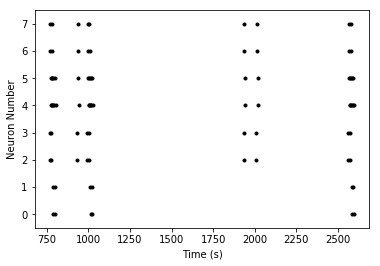

In [13]:
# Basic raster plot
plt.plot(spks[:, 0], spks[:, 1], '.k')
# plt.xlim(0, config_file['run']['duration'])
plt.ylim(-0.5, 7.5)
plt.xlabel('Time (s)')
plt.ylabel('Neuron Number')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px; \">
<h2>Homework exercises:</h2>
<p>1. Explore the directory structure created from this notebook that represents the network  
<p>2. Explore the directory components that was created for you and contains more cell types  
<p>3. Download and HDF5 viewer and explore the .h5 files created.  
<p>4. Simulate one biophysical neuron receiving a large number of balanced excitatory and inhibitory inputs. Choose a cell model other than Scnn1a or PV1. Explore the effects of changing the target locations (somatic, basal, apical) of the excitatory and inhibitory inputs.  
<p>5. We have another directory >>pointnet_notebook that shows how to use the same files and circuit created here to run a point neural network simulation. The simulator engine is NEST (http://www.nest-simulator.org/) and some changes had to be made to the config file and network description (documented in the notebook) based on NEST nomenclature requirements. Feel free to explore and play around with the notebook and NEST.
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h2>Project Ideas:</h2>
<p>1. Compare visual responses between the Layer 4 model and Brain Observatory.  

<p>2. Find an optimal kernel for converting spikes from the Layer 4 model to Ca2+ signal, to maximize the agreeement with the Brain Observatory data.  

<p>3. Build a small-scale point-neuron network model receiving visual inputs; run simulations to explore visual responses.  

<p>4. Build a small-scale point-neuron network; explore the effect of different connectivity rules on the spatio-temporal dynamics.  

<p>5. Build a population-statistics DiPDE model analogous to the biophysical Layer 4 model.  Investigate whether similar dynamics can be obtained.  

<p>6. Build a population-statistics DiPDE model of all cortical layers.  Explore cortical dynamics in simulations.  
</div>